# Test Greykite

### Imports

In [32]:
%matplotlib inline

import pandas as pd
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday
from greykite.algo.forecast.silverkite.constants.silverkite_seasonality import SilverkiteSeasonalityEnum
from greykite.algo.forecast.silverkite.forecast_simple_silverkite_helper import cols_interact
from greykite.common import constants as cst
from greykite.common.features.timeseries_features import build_time_features_df
from greykite.common.features.timeseries_features import convert_date_to_continuous_time
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.detection.detector.greykite import GreykiteDetector
from greykite.detection.detector.config import ADConfig
from greykite.detection.detector.data import DetectorData
from greykite.common.constants import GrowthColEnum

import plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import psycopg2

import warnings
warnings.filterwarnings('ignore')

## Read dataset from farmago v1 and farmago v2

In [33]:
fg_full_csv = pd.read_csv('./ts_fg.csv')
df = pd.DataFrame(fg_full_csv)
df = df[df['principio_activo'] == 'ACETAMINOFEN']
df = df[df['qty'] > 0]
df['date'] = pd.to_datetime(df['date'])
df

,principio_activo,name,date,qty,price_unit,branch_id
2,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 30 TABLETAS (...,2023-12-29,1.0,95.23,10.0
4,ACETAMINOFEN,{'en_US': 'TACHIPIRIN GOTAS PEDIATRICAS (ACETA...,2023-12-23,1.0,147.81,2.0
5,ACETAMINOFEN,{'en_US': 'ATAEML FORTE (ACETAMINOFEN) 650MG X...,2023-12-24,1.0,120.97,2.0
10,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 500MG X 20 TABLETAS (...,2023-12-23,1.0,66.93,2.0
11,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 30 TABLETAS (...,2023-12-23,1.0,94.86,19.0
...,...,...,...,...,...,...
92275,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 500MG X 10 COMPRIMIDOS...,2025-01-04,1.0,42.58,34.0
92276,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 10 COMPRIMIDOS...,2024-12-31,1.0,39.54,48.0
92277,ACETAMINOFEN,{'en_US': 'ANALPER JARABE (ACETAMINOFEN) 150MG...,2024-12-31,1.0,167.01,48.0
92278,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 10 COMPRIMIDOS...,2024-12-31,1.0,39.54,48.0


Hist by branch

<AxesSubplot:ylabel='Frequency'>

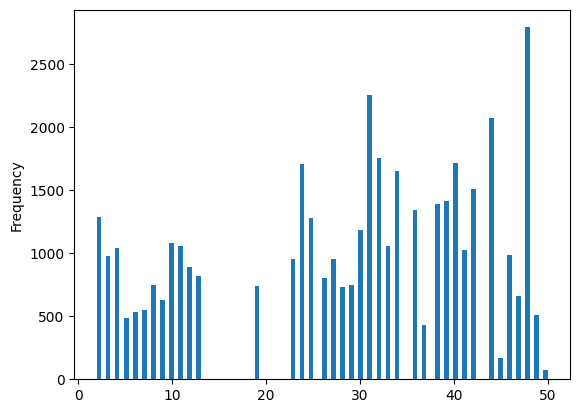

In [34]:
df['branch_id'].plot.hist(bins=100 )

## Load active branchs by days 


In [35]:
active_branches_df = pd.read_csv('./branch_by_day.csv')
active_branches_df = pd.DataFrame(active_branches_df)
active_branches_df['date'] = pd.to_datetime(active_branches_df['date'])
active_branches_df = active_branches_df.rename(columns={'date': 'ts', 'count': 'nro_branches'})
active_branches_df = active_branches_df[(active_branches_df['ts'] > '2024-05-01') & (active_branches_df['ts'] < '2025-05-21')]
active_branches_df

,ts,nro_branches
181,2024-05-02,16
182,2024-05-03,16
183,2024-05-04,16
184,2024-05-05,14
185,2024-05-06,16
...,...,...
560,2025-05-16,25
561,2025-05-17,25
562,2025-05-18,23
563,2025-05-19,25


## load products by principio activo sold

In [36]:
products_df = pd.read_csv('./products_by_day.csv')
products_df = pd.DataFrame(products_df)
products_df = products_df[products_df['principio_activo'] == 'ACETAMINOFEN']
products_df = products_df.rename(columns={'date': 'ts', 'count': 'nro_products'})
products_df['ts'] = pd.to_datetime(products_df['ts'])
products_df = products_df[(products_df['ts'] > '2024-05-01') & (products_df['ts'] < '2025-05-21')]
products_df = products_df.drop(columns=['principio_activo'])
products_df

,ts,nro_products
362,2024-05-02,16
364,2024-05-03,16
366,2024-05-04,13
368,2024-05-05,8
370,2024-05-06,14
...,...,...
1120,2025-05-16,17
1122,2025-05-17,16
1124,2025-05-18,14
1126,2025-05-19,16


## Sum sales of each sucursal

In [37]:
df_sum = df.groupby(['date', 'principio_activo'])['qty'].sum().reset_index()
df_sum = df_sum.rename(columns={'date': 'ts', 'qty': 'y'})
df_sum = df_sum[(df_sum['ts'] > '2024-05-01') & (df_sum['ts'] < '2025-05-21')]
df_sum['ts'] = pd.to_datetime(df_sum['ts'])
df_sum.describe()

,y
count,384.000000
mean,108.476562
std,50.666054
min,13.000000
25%,68.000000
50%,101.500000
75%,147.000000
max,315.000000


Hist of qty of sales

<AxesSubplot:ylabel='Frequency'>

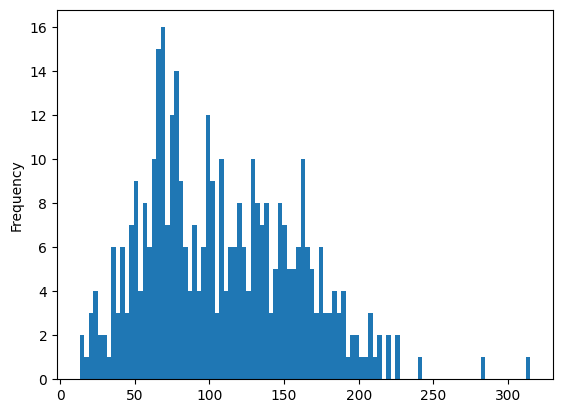

In [38]:
df_sum['y'].plot.hist(bins=100 )


## Load regressors

In [39]:
df_full = pd.merge(df_sum, active_branches_df, on=['ts'], how='left')
df_full = pd.merge(df_full, products_df, on=['ts'], how='left')
df_full

,ts,principio_activo,y,nro_branches,nro_products
0,2024-05-02,ACETAMINOFEN,52.0,16,16
1,2024-05-03,ACETAMINOFEN,61.0,16,16
2,2024-05-04,ACETAMINOFEN,35.0,16,13
3,2024-05-05,ACETAMINOFEN,15.0,14,8
4,2024-05-06,ACETAMINOFEN,39.0,16,14
...,...,...,...,...,...
379,2025-05-16,ACETAMINOFEN,221.0,25,17
380,2025-05-17,ACETAMINOFEN,207.0,25,16
381,2025-05-18,ACETAMINOFEN,96.0,23,14
382,2025-05-19,ACETAMINOFEN,315.0,25,16


<AxesSubplot:>

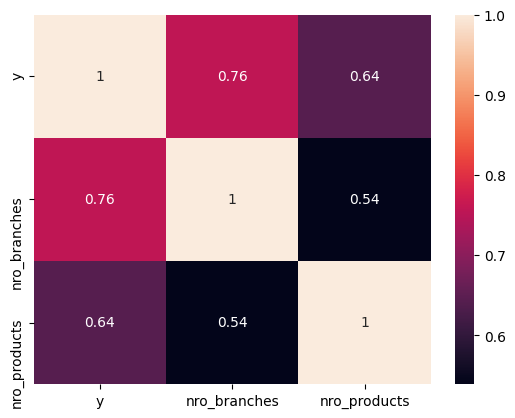

In [ ]:
df_full.corr()
sns.heatmap(df_full.corr(), annot=True)

In [41]:
# df_full['nro_branches_lag1'] = df_full['nro_branches'].shift(1)
# df_full['nro_products_lag1'] = df_full['nro_products'].shift(1)
# df_full['nro_branches_lag7'] = df_full['nro_branches'].shift(7)
# df_full['nro_products_lag7'] = df_full['nro_products'].shift(7)
# df_full = df_full.dropna().reset_index(drop=True)
df_full

,ts,principio_activo,y,nro_branches,nro_products
0,2024-05-02,ACETAMINOFEN,52.0,16,16
1,2024-05-03,ACETAMINOFEN,61.0,16,16
2,2024-05-04,ACETAMINOFEN,35.0,16,13
3,2024-05-05,ACETAMINOFEN,15.0,14,8
4,2024-05-06,ACETAMINOFEN,39.0,16,14
...,...,...,...,...,...
379,2025-05-16,ACETAMINOFEN,221.0,25,17
380,2025-05-17,ACETAMINOFEN,207.0,25,16
381,2025-05-18,ACETAMINOFEN,96.0,23,14
382,2025-05-19,ACETAMINOFEN,315.0,25,16


In [42]:
freq = 'D'

ts = UnivariateTimeSeries()
ts.load_data(
    df=df_sum,
    time_col="ts",
    value_col="y",
    freq=freq
    # anomaly_info=anomaly_info,
    # regressor_cols=["sale_price"]
)

ts.plot()

In [43]:
# No es un dataframe pero pareceira un dataframe5
ts = UnivariateTimeSeries()
ts.load_data(
    df=df_full,
    time_col="ts",
    value_col="y",
    freq=freq
    # anomaly_info=anomaly_info,
    # regressor_cols=["sale_price"]
)

metadata = MetadataParam(
    time_col='ts', # Usa el nombre de tu columna de tiempo
    value_col='y',  # Usa el nombre de tu columna de valor
    freq=freq,       # Frecuencia diaria
    # train_end_date=None, # Greykite lo determinará
    # anomaly_info=None    # Si no tienes etiquetas de anomalías para el entrenamiento
)

# EvaluationPeriodParam (para AD, a menudo se ajusta para no tener un test_horizon largo en el config inicial)
evaluation_period = EvaluationPeriodParam(
    test_horizon=0,       # Para AD, el foco es el ajuste en los datos de entrenamiento
    cv_max_splits=0       # Para AD, el CV se maneja de forma diferente o se simplifica
)

# ModelComponentsParam
model_components = ModelComponentsParam(
    autoregression={
        "autoreg_dict": {
            "lag_dict": {"orders": [1, 7]},
            "agg_lag_dict": {"orders_list": [(1, 7)]}
        }
    },
    events={ # Configuración de eventos/festivos (ajusta a tu país/necesidad)
        "auto_holiday": False,
         "holidays_to_model_separately": "auto",
         "holiday_lookup_countries": "auto",
         "holiday_pre_num_days": 2,
         "holiday_post_num_days": 2,
         "holiday_pre_post_num_dict": None,
         "daily_event_df_dict": None, # Puedes pasar un df con eventos custom aquí
    },
    lagged_regressors={ # Greykite crea los lags para estos regresores
        "lagged_regressor_dict": {
            'nro_branches': { # Nombre de la columna original en tu df_full
                "lag_dict": {"orders": [1, 7]}, # Quiero lag 1 y lag 7 de nro_branches
                # "agg_lag_dict": {"interval_list": [(1,7)]} # Opcional: promedio de lags
            },
            'nro_products': "auto" # Dejar que Greykite elija lags para nro_products
        }
    },
    custom={ # Aquí van los regresores para templates como SILVERKITE_EMPTY
        "min_admissible_value": 0, # Si tus ventas no pueden ser negativas
        "normalize_method": "zero_to_one" # O "mean_std", o None
    }
)

In [44]:
anomaly_detector = GreykiteDetector()  # Creates an instance of the Greykite anomaly detector

# ForecastConfig
forecast_config = ForecastConfig( # Renombrado para evitar confusión si tienes otro forecast_config
    model_template=ModelTemplateEnum.AUTO.name, # El template del tutorial de AD
    metadata_param=metadata,
    model_components_param=model_components,
    coverage=None,  # Importante para que AD ajuste las bandas de confianza
    # evaluation_period_param=evaluation_period,
    forecast_horizon=1 # Para AD, el horizonte de pronóstico puede ser corto
                       # ya que se enfoca en la bondad de ajuste al histórico.
)

ad_config = ADConfig()  # Default anomaly detection config

detector = GreykiteDetector(
    forecast_config=forecast_config,
    ad_config=ad_config,
    reward=None)

In [45]:
train_data = DetectorData(df=df_full)
train_data
detector.fit(data=train_data)

2025-05-30 12:25:21 Greykite [WARNING]: No anomalies are provided and no outliers have been found. Setting 'anomaly_df' to None.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [46]:
print(detector.fitted_df[detector.fitted_df["is_anomaly_predicted"] == False])

fig = detector.plot(
    phase="train",
    title="Greykite Detector Peyton Manning - fit phase")
plotly.io.show(fig)

            ts  actual    forecast  forecast_lower  forecast_upper  \
47  2024-06-18    65.0   66.272932       64.786599       67.759264   
58  2024-06-29    57.0   58.235861       56.749528       59.722194   
63  2024-07-04    68.0   68.995117       67.508784       70.481450   
68  2024-07-09    79.0   79.248831       77.762498       80.735163   
80  2024-07-21    49.0   48.681776       47.195444       50.168109   
89  2024-07-30    93.0   92.336011       90.849678       93.822343   
100 2024-08-10    61.0   61.725226       60.238893       63.211559   
108 2024-08-18    47.0   45.835384       44.349052       47.321717   
129 2024-09-08    41.0   41.901424       40.415091       43.387757   
153 2024-10-02   114.0  113.235254      111.748921      114.721587   
248 2025-01-05    66.0   67.252759       65.766426       68.739091   
255 2025-01-12    50.0   50.951919       49.465587       52.438252   
263 2025-01-20   107.0  107.413082      105.926749      108.899414   
265 2025-01-22   121

In [47]:

print(detector.summary())

======================= Anomaly Detection Model Summary ========================

Number of observations: 384
Model: GreykiteDetector
Number of detected anomalies: 363

Average Anomaly Duration: 16 days 12:00:00
Minimum Anomaly Duration: 1 days 00:00:00
Maximum Anomaly Duration: 94 days 00:00:00

Alert Rate(%): 94.53125
Optimal Objective Value: 0
Optimal Parameters: {'coverage': 0.05, 'volatility_features': []}

============================ Forecast Model Summary ============================

Number of observations: 384,   Number of features: 122
Method: Ridge regression
Number of nonzero features: 122
Regularization parameter: 16.1

Residuals:
         Min           1Q       Median           3Q          Max
      -110.8       -13.16       -1.438        12.99        135.6

            Pred_col Estimate Std. Err Pr(>)_boot sig. code              95%CI
           Intercept    14.07     12.7      0.258              (-8.237, 41.31)
 events_C...New Year   -2.305    1.221      0.042         

<AxesSubplot:ylabel='Frequency'>

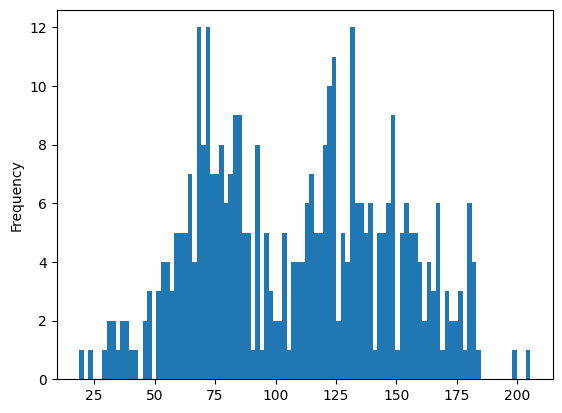

In [48]:
df_fited = detector.fitted_df.rename(columns={"forecast": "y"})

df_fited['y'].plot.hist(bins=100 )

In [49]:
products_df

,ts,nro_products
362,2024-05-02,16
364,2024-05-03,16
366,2024-05-04,13
368,2024-05-05,8
370,2024-05-06,14
...,...,...
1120,2025-05-16,17
1122,2025-05-17,16
1124,2025-05-18,14
1126,2025-05-19,16


In [50]:
df_fited_reduce = df_fited[['ts', 'y']]

df_fited_reduce['ts'] = pd.to_datetime(df_fited_reduce['ts'])

df_new = pd.merge(df_fited_reduce, active_branches_df, on=['ts'], how='left')
df_new = pd.merge(df_new, products_df, on=['ts'], how='left')


df_new

,ts,y,nro_branches,nro_products
0,2024-05-02,65.152436,16,16
1,2024-05-03,57.358490,16,16
2,2024-05-04,50.632580,16,13
3,2024-05-05,34.604424,14,8
4,2024-05-06,58.127684,16,14
...,...,...,...,...
379,2025-05-16,198.150910,25,17
380,2025-05-17,168.078291,25,16
381,2025-05-18,122.878376,23,14
382,2025-05-19,179.428020,25,16


### Forecasting

In [51]:
forecaster = Forecaster()

model_components_param_silverkite = ModelComponentsParam(
     seasonality={
         "auto_seasonality": False,
         "yearly_seasonality": "auto",
         "quarterly_seasonality": "auto",
         "monthly_seasonality": "auto",
         "weekly_seasonality": "auto",
         "daily_seasonality": "auto",
     },
     growth={
         "growth_term": GrowthColEnum.linear.name
     },
     events={
         "auto_holiday": False,
         "holidays_to_model_separately": "auto",
         "holiday_lookup_countries": "auto",
         "holiday_pre_num_days": 2,
         "holiday_post_num_days": 2,
         "holiday_pre_post_num_dict": None,
         "daily_event_df_dict": None,
     },
     changepoints={
         "auto_growth": False,
         "changepoints_dict": {
             "method": "auto",
             "yearly_seasonality_order": 15,
             "resample_freq": "3D",
             "regularization_strength": 0.6,
             "actual_changepoint_min_distance": "30D",
             "potential_changepoint_distance": "15D",
             "no_changepoint_distance_from_end": "90D"
         },
         "seasonality_changepoints_dict": None
     },
     autoregression={
        "autoreg_dict": {
            "lag_dict": {"orders": [1, 7]},
            "agg_lag_dict": {"orders_list": [(1, 7)]}
        }
    },
     regressors={
         "regressor_cols": []
     },
     lagged_regressors={ # Greykite crea los lags para estos regresores
        "lagged_regressor_dict": {
            'nro_branches': { # Nombre de la columna original en tu df_full
                "lag_dict": {"orders": [1, 7]}, # Quiero lag 1 y lag 7 de nro_branches
                # "agg_lag_dict": {"interval_list": [(1,7)]} # Opcional: promedio de lags
            },
            'nro_products': "auto" # Dejar que Greykite elija lags para nro_products
        }
    },
     uncertainty={
         "uncertainty_dict": None
     },
     custom={
         "fit_algorithm_dict": {
             "fit_algorithm": "ridge",
             "fit_algorithm_params": None,
         },
         "feature_sets_enabled": "auto",  # "auto" based on data freq and size
         "max_daily_seas_interaction_order": 5,
         "max_weekly_seas_interaction_order": 2,
         "extra_pred_cols": [],
         "drop_pred_cols": None,
         "explicit_pred_cols": None,
         "min_admissible_value": None,
         "max_admissible_value": None,
         "normalize_method": "zero_to_one"
     }
 )


result = forecaster.run_forecast_config(
            df=df_new,
            config=ForecastConfig(
                model_template=ModelTemplateEnum.AUTO.name,
                forecast_horizon=10, 
                coverage=0.95,
                metadata_param=metadata,
                model_components_param=model_components_param_silverkite,
                # evaluation_period_param=evaluation_period 
            )
        )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
result_auto = forecaster.run_forecast_config(
            df=df_new,
            config=ForecastConfig(
                model_template=ModelTemplateEnum.AUTO.name,
                forecast_horizon=10, 
                coverage=0.95,
                metadata_param=metadata,
                # model_components_param=ModelComponentsParam(
                #     lagged_regressors={ # Greykite crea los lags para estos regresores
                #         "lagged_regressor_dict": {
                #             'nro_branches': { # Nombre de la columna original en tu df_full
                #                 "lag_dict": {"orders": [1, 7]}, # Quiero lag 1 y lag 7 de nro_branches
                #                 # "agg_lag_dict": {"interval_list": [(1,7)]} # Opcional: promedio de lags
                #             },
                #             'nro_products': "auto" # Dejar que Greykite elija lags para nro_products
                #         }
                #     }
                # ),
                # evaluation_period_param=evaluation_period 
            )
        )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [53]:
result.forecast.plot()

In [63]:
result_auto.forecast.plot()

In [55]:
frecast_wo_2025_df = result.forecast.df_test

frecast_wo_2025_df

frecast_wo_2025_df[frecast_wo_2025_df['ts'] > '2025-05-20']['forecast_lower'].sum()

1563.5308667090508

In [56]:
frecast_wo_2025_df.describe()

,actual,forecast,forecast_lower,forecast_upper
count,0.0,10.000000,10.000000,10.000000
mean,NaN,173.186224,156.353087,186.028246
std,NaN,25.734003,25.990846,24.423055
min,NaN,112.178310,97.758531,126.790921
25%,NaN,163.713894,149.137254,176.741955
50%,NaN,176.135613,157.093261,191.560730
75%,NaN,192.613478,172.333897,203.294751
max,NaN,198.488879,186.492209,209.013005


In [57]:
print(pd.DataFrame(result.backtest.test_evaluation, index=["Value"]).transpose())

                                                         Value
CORR                                                  0.928208
R2                                                    0.359119
MSE                                                 745.493919
RMSE                                                 27.303735
MAE                                                  24.136398
MedAE                                                27.856999
MAPE                                                 14.304295
MedAPE                                               14.817369
sMAPE                                                 7.910968
Q80                                                  19.309118
Q95                                                  22.929578
Q99                                                  23.895034
OutsideTolerance1p                                         1.0
OutsideTolerance2p                                         1.0
OutsideTolerance3p                                     

In [64]:
print(pd.DataFrame(result_auto.backtest.test_evaluation, index=["Value"]).transpose())



                                                         Value
CORR                                                   0.97253
R2                                                     0.78663
MSE                                                 248.199111
RMSE                                                 15.754336
MAE                                                  13.803659
MedAE                                                14.034911
MAPE                                                  8.175524
MedAPE                                                7.863981
sMAPE                                                 4.310022
Q80                                                  10.827015
Q95                                                  12.789608
Q99                                                  13.312966
OutsideTolerance1p                                         0.9
OutsideTolerance2p                                         0.9
OutsideTolerance3p                                     

In [65]:
result_auto.model

Pipeline(steps=[('input',
                 PandasFeatureUnion(transformer_list=[('date',
                                                       Pipeline(steps=[('select_date',
                                                                        ColumnSelector(column_names=['ts']))])),
                                                      ('response',
                                                       Pipeline(steps=[('select_val',
                                                                        ColumnSelector(column_names=['y'])),
                                                                       ('outlier',
                                                                        DifferenceBasedOutlierTransformer()),
                                                                       ('null',
                                                                        NullTransformer(impute_algorithm='interpolate',
                                                                                        impute_params={'axis': 0,
                                                                                                       'lim...
                                                            'simple_freq': <SimpleTimeFrequencyEnum.DAY: Frequency(default_horizon=30, seconds_per_observation=86400, valid_seas={'WEEKLY_SEASONALITY', 'MONTHLY_SEASONALITY', 'QUARTERLY_SEASONALITY', 'YEARLY_SEASONALITY'})>,
                                                            'start_year': 2024},
                                           uncertainty_dict={'params': {'conditional_cols': ['dow_hr'],
                                                                        'quantile_estimation_method': 'normal_fit',
                                                                        'quantiles': [0.025000000000000022,
                                                                                      0.975],
                                                                        'sample_size_thresh': 5,
                                                                        'small_sample_size_method': 'std_quantiles',
                                                                        'small_sample_size_quantile': 0.98},
                                                             'uncertainty_method': 'simple_conditional_residuals'}))])

In [60]:
# retail_csv = pd.read_csv('./data_productos_ventas_3.csv')
# df_real = pd.DataFrame(retail_csv)
# df_real['fecha_venta'] = pd.to_datetime(df_real['fecha_venta'])

# df_real = df_real.query('`codigo_articulo` == 386')
    
# # # df_real = df_real.groupby(['fecha_venta']).agg({'cantidad': 'sum'}).reset_index()
# df_real.rename(columns={'fecha_venta': 'ts', 'cantidad': 'y'}, inplace=True)
# df_real = df_real.groupby(pd.Grouper(key='ts', freq=freq)).agg({'y': 'sum'}).reset_index()


# ts2025 = UnivariateTimeSeries()
# ts2025.load_data(
#     df=df_real,
#     time_col="ts",
#     value_col="y",
#     freq=freq
#     # anomaly_info=anomaly_info,
#     # regressor_cols=["sale_price"]
# )

# ts2025.plot()

In [61]:
# df_real[df_real['ts'] >= '2025-01-01']['y'].describe()
# df_real.describe()